<img src="Imgs/Img-001.png" alt="Drawing" style="width:250px;"/>

# Notícias Ethereum - Análize Diária   (Web Scraper)

### Objetivo:
Investidores diariamente acompanham notícias de cripto moedas como parâmetro para formulação de estratégias e tomadas de decisão.<br>
No entanto, existem investidores com portfólios muito variados e que não possuem tempo para analisar a situação de cada ativo diariamente e precisão de um feedback rápido, ou simplesmente está em um dia mais corrido em que não se consegue ter tempo para realizar uma análize mais completa. Com isso dito esse projeto objetiva criar um "termômetro" dos acontecimentos diários para uma moeda cripto moeda específica.<br>
Outro uso é como parâmetro auxiliar para bots investidores. Este scraper retorna um número inteiro facilmente interpretável e de fácil integração para com algoritmos de previsão.

### Por que Ethereum?
Ethereum é segundo a [forbes](https://www.forbes.com/sites/bernardmarr/2018/02/02/blockchain-a-very-short-history-of-ethereum-everyone-should-read/#496c3f7e1e89), um dos melhores investimentos em cripto moedas da atualidade e que deve ultrapassar o bitcoin em algum momento próximo. No entanto, o Bitcoin ainda é (em 24/08/2019) o líder do mercado e a maior parte das notícias são voltadas para o mesmo. Então investidores normalmente acessam dezenas de notícias diárias de bitcoin, que é uma base para toda a cryptocurrency, porém, quando necessitam de informação sobre Ethereum, precisam buscar em lugares diferentes, criando assim um segundo gasto de tempo. Logo com esse projeto, quando houver uma necessidade de um parâmetro básico para uma análise diária rápida da tendência da moeda, basta executar este web scraper. 


---
## Analisando Sites de Notícias

Cada site de notícia possui padrão de disposição de informação diferente, logo cada análise será realizada de forma diferente. No entanto, será criado uma função para a abertura e leitura dos sites que será praticamente igual para todos, as variações serão controladas dentro dos parâmetros:

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

from urllib.request import Request,urlopen
from bs4 import BeautifulSoup

In [2]:
hoje = dt.date.today().day

In [3]:
variacao = 0
def buscando_html(news_url, variacao):
    if variacao == 1:
        html_page = urlopen(news_url)
        return BeautifulSoup(html_page, 'lxml')
    if variacao == 2:
        hdr = {'User-Agent': 'Mozilla/5.0'} 
        req = Request(news_url,headers=hdr)
        html_page = urlopen(req)
        return BeautifulSoup(html_page, 'lxml')

#### Padrões dos Sites:
Analisando sites de notícias percebe-se dois padrões:
* Sites com **uma ou nenhuma notícia diária**, esses sites são focados em notícias mais impactantes. Exemplo: [infomoney](https://www.infomoney.com.br/cryptos/ethereum/pagina/1) <br><br>
* Sites com **várias notícias diárias**, esses sites cobrem uma grande variedade de acontecimentos, que podem influenciar pouco ou muito na moeda. Exemplo: [independent-en](https://www.independent.co.uk/topic/ethereum)




Portanto, dividiremos os sites em dois grupos, sendo que cada grupo terá um peso diferente em sua notícia:
* **Grupo 01:** Notícias menos impactantes Peso vezes 1.
* **Grupo 02:** Notícias mais impactantes Peso vezes 2.

#### Grupo 01:
* [independent-en](https://www.independent.co.uk/topic/ethereum)
* [investing-en](https://investing.com/crypto/ethereum/news)

    
    
#### Grupo 02:
* [infomoney-br](https://www.infomoney.com.br/cryptos/ethereum/pagina/1)
* [guia do bitcoin-pt](https://guiadobitcoin.com.br/categoria/altcoins/ethereum-eth/)
* [webitcoin-pt](https://webitcoin.com.br/?s=ethereum)
* [google-noticias-pt](https://www.google.com/search?q=noticias+ethereum&source=lnms&tbm=nws&sa=X&ved=0ahUKEwikrtfrrZzkAhXyH7kGHbSUCoMQ_AUIESgB&biw=1242&bih=553)

    


#### Palavras Chaves:
Para analisar se uma notícia é positiva ou negativa serão adotadas palavras chaves, caso a notícia contenha alguma delas, determinará se a pontuação será positiva ou negativa.
**Você pode modificar as palavras conforme a sua necessidade, só tenha em mente que é importante ter uma quantidade balanceada de palavras negativas e positivas, caso contrário será gerado uma tendência.**

In [4]:
palavras_negativas_pt = ["crise", "proib", "afeta", "cai", "desaba", "bloquead", "quebra", "baixa", "polemica", "advert", "medo", "caos", "terrorista"]
palavras_positivas_pt = ["dispara", "supera", "valoriza", "invest", "promete", "lança", "nov", "subi", "popular", "avança", "alta"]

palavras_negativas_en = ["low", "leav", "fall", "down", "lock", "drop", "dump"]
palavras_positivas_en = ["high", "join", "rise", "up", "release", "surge"]

A análise das notícias com as palavras chaves também possuem um padrão, com apenas duas diferenças: 
1. Se o site está contido no grupo 1 ou no grupo 2.
2. Se o site está em português ou inglês.


Logo será criado uma função para lidar com isso:

In [5]:
pontuacao = 0
grupo = 0
#Parâmetros:
# noticias, sera a lista de strings que representa as noticias de um site
# grupo, sera um inteiro que é o valor que deve ser somado ao balanço final
def pontuacao_do_site(noticias, grupo, lingua):
    global pontuacao
    if lingua == "pt":
        for frase in noticias:
            for palavra in palavras_negativas_pt:
                if(palavra in frase):
                    pontuacao -= grupo
            for palavra in palavras_positivas_pt:
                if(palavra in frase):
                    pontuacao += grupo
    if lingua == "en":
        for frase in noticias:
            for palavra in palavras_negativas_en:
                if(palavra in frase):
                    pontuacao -= grupo
            for palavra in palavras_positivas_en:
                if(palavra in frase):
                    pontuacao += grupo
                

---

## Realizando Buscas

In [6]:
pontos_por_site = []
sites = []

### Grupo 01

* [independent-en](https://www.independent.co.uk/topic/ethereum)

In [7]:
url = "https://www.independent.co.uk/topic/ethereum?CMP=ILC-refresh"
soup_html = buscando_html(url,2)

aux = pontuacao
# O site independent não possui data direta nas noticias, mas possui um feed superior que é mudado diariamente,
# então será usado apenas as notícias desse feed.
noticias = soup_html.findAll("h2")
for index in range(len(noticias)):
    noticias[index] = noticias[index].contents[0].lower()
pontuacao_do_site(noticias, 1, "en")

sites.append("independent")
pontos_por_site.append(pontuacao - aux)

<br><br>
* [investing-en](https://investing.com/crypto/ethereum/news)

In [8]:
aux = pontuacao
url = "https://investing.com/crypto/ethereum/news/"
soup_html = buscando_html(url,2)
noticias_hoje = []
#print("algo; ",soup_html)

#Neste site em particular as noticias das ultimas 24hrs sao dadas em horas
#1. verificamos quantas noticias sao atuais:
datas = soup_html.findAll("span", {"class":"date"})

qtd_noticias = 0
for data in datas:
    data = ''.join(data)
    if "hours" in data:
        global qtd_noticias
        qtd_noticias += 1
        
#2. Se houver noticias de hoje:
if qtd_noticias != 0:
    global noticias_hoje
    noticias_hoje = soup_html.findAll("a", {"class":"title"})[:qtd_noticias]
    for index in range(qtd_noticias):
        noticias_hoje[index] = noticias_hoje[index].contents[0].lower()
    pontuacao_do_site(noticias_hoje, 1, "en")
    
sites.append("investing")
pontos_por_site.append(pontuacao - aux)

### Grupo 02

* [infomoney-br](https://www.infomoney.com.br/cryptos/ethereum/pagina/1)

In [9]:
aux = pontuacao
url = "https://www.infomoney.com.br/cryptos/ethereum/pagina/1"
soup_html = buscando_html(url,1)

#Verificando se a ultima noticia eh atual
dia_ultima_noticia = soup_html.findAll("div", {"class":"info-box info-box-medium"})[0].div.contents[2][1:3]
dia_ultima_noticia = int(dia_ultima_noticia)

if hoje == dia_ultima_noticia:
    noticia = soup_html.findAll("a", {"class":"title-box title-box-medium"})[0].contents[0].lower()
    noticias = []
    noticias.append(noticia)
    pontuacao_do_site(noticias, 2, "pt")
    
sites.append("infomoney")
pontos_por_site.append(pontuacao - aux)

<br><br>
* [guia do bitcoin-pt](https://guiadobitcoin.com.br/categoria/altcoins/ethereum-eth/)

In [10]:
aux = pontuacao
url = "https://guiadobitcoin.com.br/categoria/altcoins/ethereum-eth/"
soup_html = buscando_html(url,2)

#Verificando a data
#No caso do guiabitcoin, quando ha noticia, eh apenas uma por dia, logo soh precisamos verificar a data da primeira
data_ultima_noticia = soup_html.findAll("span", {"class":"post-author"})[1].contents[0][-8:-6]

if hoje == int(data_ultima_noticia):
    noticia = soup_html.findAll("p")[0].contents[0].lower()
    noticias = []
    noticias.append(noticia)
    pontuacao_do_site(noticias, 2, "pt")
    
sites.append("guia_do_bitcoin")
pontos_por_site.append(pontuacao - aux)

<br><br>
* [webitcoin](https://webitcoin.com.br/?s=ethereum)

In [11]:
aux = pontuacao
url = "https://webitcoin.com.br/?s=ethereum"
soup_html = buscando_html(url,1)

#A webitcoin tambem solta apenas uma noticia por dia
noticia = soup_html.findAll("h3")[1].contents[0].lower()
noticias = []
noticias.append(noticia)
pontuacao_do_site(noticias, 2, "pt")

sites.append("webitcoin")
pontos_por_site.append(pontuacao - aux)

<br><br>
* [google-noticias-pt](https://www.google.com/search?q=noticias+ethereum&source=lnms&tbm=nws&sa=X&ved=0ahUKEwikrtfrrZzkAhXyH7kGHbSUCoMQ_AUIESgB&biw=1242&bih=553)

In [12]:
aux = pontuacao
url = "https://www.google.com/search?q=noticias+ethereum&source=lnms&tbm=nws&sa=X&ved=0ahUKEwikrtfrrZzkAhXyH7kGHbSUCoMQ_AUIESgB&biw=1242&bih=553"
soup_html = buscando_html(url,2)

#No caso do google, ele fornece uma noticia principal todo dia e esta que sera usada:
todas_noticias = soup_html.findAll("a")
noticia = str(todas_noticias[39].contents[1])
noticias = []
noticias.append(noticia)
pontuacao_do_site(noticias, 2, "pt")

sites.append("google-noticias-br")
pontos_por_site.append(pontuacao - aux)

---
---
# RESULTADOS:

## Gráfico dos sites:

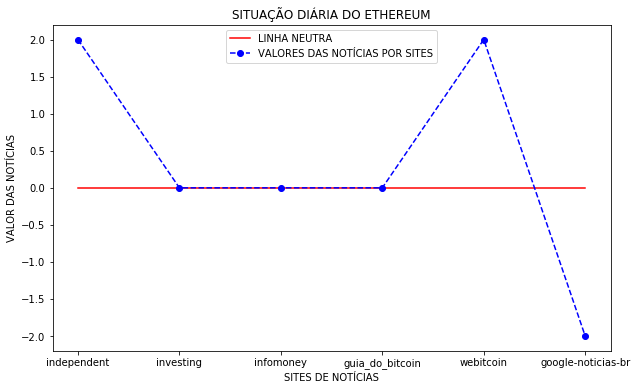

In [13]:
fig = plt.figure(figsize = (10,6))

zeros = [0]*len(sites)

plt.plot(sites, zeros, c='red', label = "LINHA NEUTRA")
plt.plot(sites, pontos_por_site, c='blue', label = "VALORES DAS NOTÍCIAS POR SITES", linestyle='--', marker='o')

plt.legend(loc='upper center')

plt.xlabel('SITES DE NOTÍCIAS')
plt.ylabel('VALOR DAS NOTÍCIAS')
plt.title('SITUAÇÃO DIÁRIA DO ETHEREUM')

plt.show()

# Valor diário de referência:

Lembrando que um espectro de valores de referência que pode ser utilizado, considerando a quantidade de sites utilizados, é: 
* **Entre -5 e 5**: É um dia **neutro** de acontecimentos da moeda;
* **Maiores que 5**:  É um dia com acontecimentos que **favorecem o valor** da moeda;
* **Menores que -5**: É um dia com acontecimentos **negativos para o valor** da moeda.

In [14]:
print("\n\nValor referência de notícias da moeda para o dia ", dt.date.today(),":   ", pontuacao)
if(pontuacao>5): 
    print("As notícias favorecem o valor da moeda.")
if(pontuacao<-5): 
    print("As notícias agem de forma negativa no valor da moeda.")
else:
    print("As notícias apontam que não deve haver mudanças bruscas com o valor da moeda.")



Valor referência de notícias da moeda para o dia  2019-08-24 :    2
As notícias apontam que não deve haver mudanças bruscas com o valor da moeda.
